<a href="https://colab.research.google.com/github/delaneybrown23/labs/blob/main/04_hedonic_pricing_DelaneyBrown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



In [8]:
# Cleaning, EDA, Visualization

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('cars_hw.csv')
print(df.dtypes, '\n')

df.head()

var = 'No_of_Owners'
df[var].unique()

# Based on the fact that the numerical variables of interest, particularly the make year, mileage, and price, were all numerical already, and there aren't dollar signs or commas, there doesn't seem to be a need for additional cleaning of this data set.

Unnamed: 0            int64
Make                 object
Make_Year             int64
Color                object
Body_Type            object
Mileage_Run           int64
No_of_Owners         object
Seating_Capacity      int64
Fuel_Type            object
Transmission         object
Transmission_Type    object
Price                 int64
dtype: object 



array(['1st', '2nd', '3rd'], dtype=object)

<Axes: >

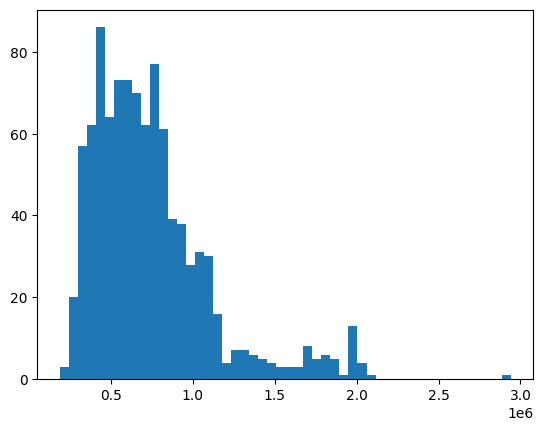

In [11]:
# EDA - Histogram

df['Price'].hist(bins=50,grid=False)

<Axes: >

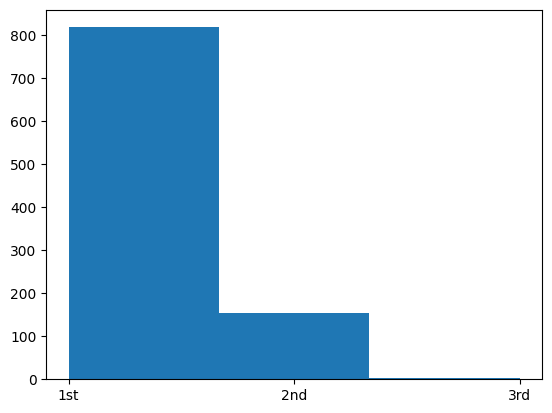

In [12]:
df['No_of_Owners'].hist(bins=3,grid=False)

<Axes: >

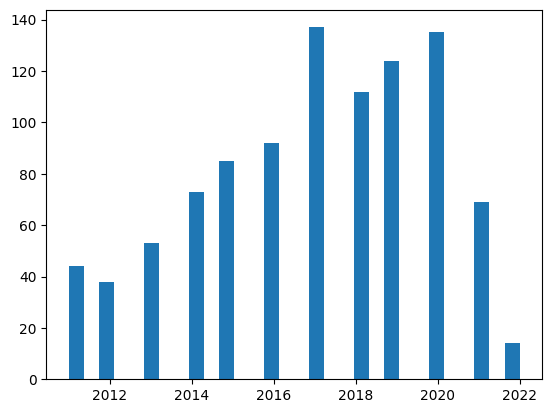

In [14]:
df['Make_Year'].hist(bins=30,grid=False)

<Axes: xlabel='No_of_Owners', ylabel='Price'>

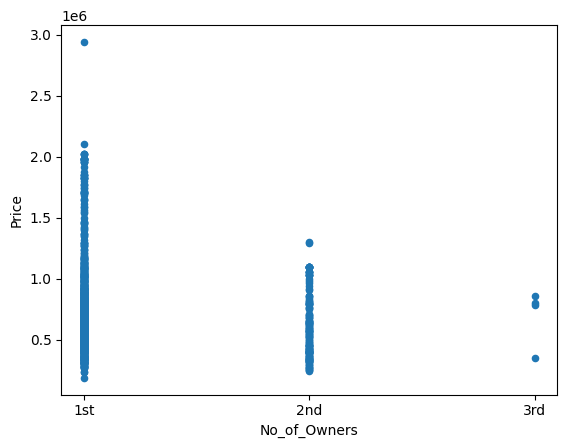

In [15]:
# Scatter plots

df.plot.scatter(y='Price',x='No_of_Owners')

<Axes: xlabel='Make_Year', ylabel='Price'>

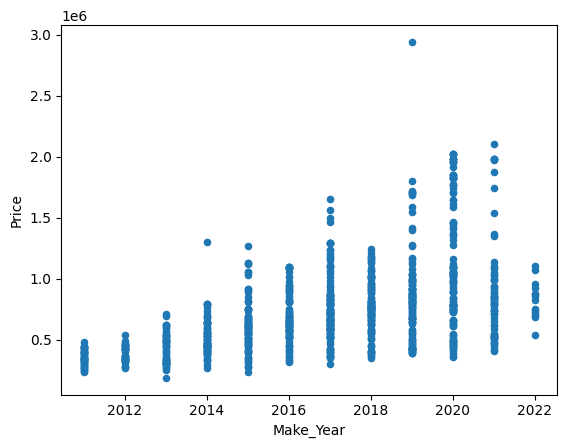

In [16]:
df.plot.scatter(y='Price',x='Make_Year')

<Axes: xlabel='Mileage_Run', ylabel='Price'>

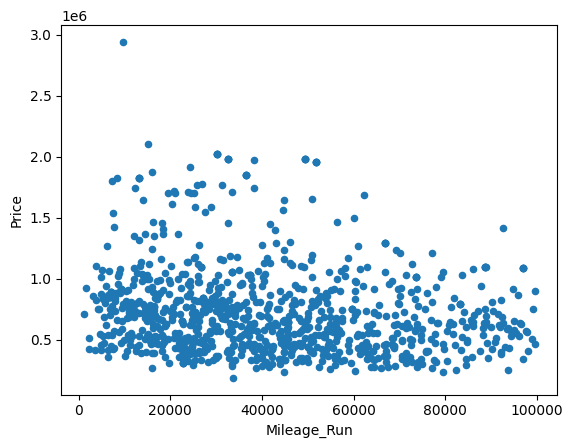

In [18]:
df.plot.scatter(y='Price',x='Mileage_Run')

<Axes: ylabel='Density'>

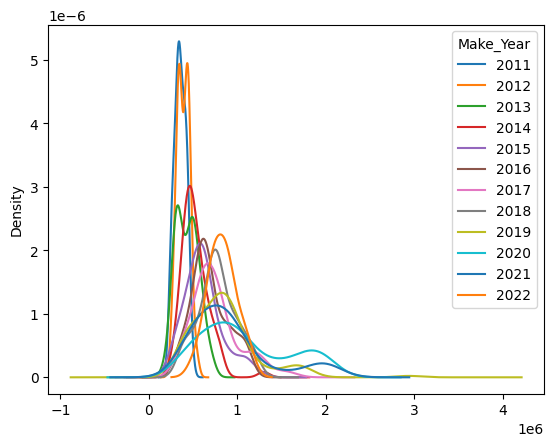

In [19]:
# Visualization

import seaborn as sns

# kernel density plot

group_by = 'Make_Year'
var = 'Price'
df_wide = df.pivot(columns=group_by,values=var)
df_wide.plot.density()

<Axes: ylabel='Density'>

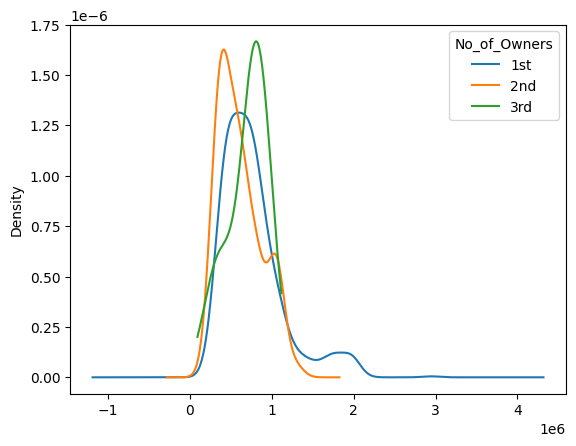

In [21]:
group_by = 'No_of_Owners'
var = 'Price'
df_wide = df.pivot(columns=group_by,values=var)
df_wide.plot.density()

In [23]:
# 80/20 train test split

y = df['Price']
X = df.loc[:,['Mileage_Run','No_of_Owners']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

In [34]:
# Simple linear model

# Attempting to run simple linear regression model on training data, but producing errors

# Price by Make
y = df['Price']
X_d = pd.get_dummies(df['Make'],dtype='int')

from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
print('R-squared: ', reg.score(X_train, y_train))
results

# Price by Mileage_Run
y = df['Price']
X_d = pd.get_dummies(df['Mileage_Run'],dtype='int')

from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
print('R-squared: ', reg.score(X_train, y_train))
results


ValueError: could not convert string to float: '1st'

In [35]:
# Trying on testing sets, but producing the same errors

y = df['Price']
X_d = pd.get_dummies(df['Make'],dtype='int')

from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False).fit(X_test, y_test)
results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
print('R-squared: ', reg.score(X_test, y_test))
results

# I unfortunately could not produce the RMSE or R squared values due to the errors that were produced when trying to run my simple linear regression models on the training and testing sets.

ValueError: could not convert string to float: '1st'

TypeError: unsupported operand type(s) for -: 'str' and 'str'

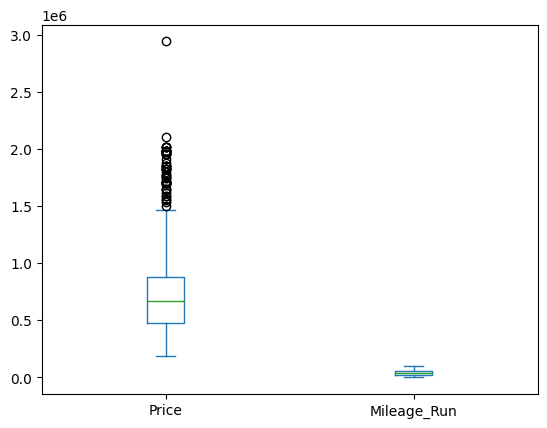

In [36]:
# More complex model with transformations and interactions

# Winsorize function

def winsorize(x):
  if type(x) == 'pandas.core.series.Series':
    x = x.to_numpy()
  pct25, pct75 = np.percentile(x,[25,75])
  iqr = pct75 - pct25
  lower_whisker = pct25 - iqr*1.5
  upper_whisker = pct75 + iqr*1.5
  x_winsor = np.copy(x)
  x_winsor[x<lower_whisker] = lower_whisker
  x_winsor[x>upper_whisker] = upper_whisker
  return(x_winsor)


y = df['Price']

# Boxplot, winsorize method with .apply
df.loc[:,['Make','Price','Mileage_Run']].plot.box()

df.loc[:, ['Make','Price','Mileage_Run']] = df.loc[:, ['Make','Price','Mileage_Run']].apply(winsorize)

df.loc[:,['Make','Price','Mileage_Run']].plot.box()

expander = PolynomialFeatures(degree=1,include_bias=False)
X_num = df.loc[:,['Mileage_Run']]
Z = expander.fit_transform(X_num)
names = expander.get_feature_names_out()
X_num = pd.DataFrame(data=Z, columns = names)

X = pd.concat([X_num,X_d],axis=1)
X.head()

# My more complicated model did produce a boxplot, but due to errors, I was not able to produce RMSE or R squared, or compare this model to the previous simple linear models, which also produced errors.

Unfortunately, due to my errors in producing the simple and complex linear models, I was not able to determine the differences between what the models produced or ultimately, which model is more efficient.